In [24]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [25]:
# Download mnist data

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [26]:
# Create model inputs

def model_inputs(discriminator_dim, generator_dim):
    discriminator_inputs = tf.placeholder(
        tf.float32,
        shape=[None, discriminator_dim],
        name='discriminator_input'
    )
    generator_inputs = tf.placeholder(
        tf.float32,
        shape=[None, generator_dim],
        name='generator_input'
    )
    return discriminator_inputs, generator_inputs

In [27]:
# Create generator

def generator(_input, out_dim, num_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        hidden_layer = tf.layers.dense(_input, num_units)
        leaky_relu = tf.maximum(hidden_layer * alpha, hidden_layer)
        
        logits = tf.layers.dense(leaky_relu, out_dim)
        return tf.tanh(logits)

In [28]:
# Create discriminator

def discriminator(_input, num_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        hidden_layer = tf.layers.dense(_input, num_units)
        leaky_relu = tf.maximum(hidden_layer * alpha, hidden_layer)
        
        logits = tf.layers.dense(leaky_relu, 1)
        return tf.sigmoid(logits), logits

In [41]:
# Set hyperparameters

discriminator_input_size = 784
generator_input_size = 100

generator_hidden_size = discriminator_hidden_size = 128

alpha = 0.01

learning_rate = 0.002

smooth = 0.1

In [42]:
# Building the network

tf.reset_default_graph()
## Create input placeholders
discriminator_input, generator_input = model_inputs(
    discriminator_input_size, generator_input_size)


## Build the model

generator_model = generator(generator_input, discriminator_input_size)

discriminator_model_real, discriminator_logits_real = discriminator(discriminator_input)
discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)

In [43]:
# Losses

## Discriminator loss real

discriminator_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(
    logits=discriminator_logits_real,
    labels=tf.ones_like(discriminator_logits_real) * (1 - smooth)
)
discriminator_loss_real = tf.reduce_mean(discriminator_loss_real)

## Discriminator loss fake

discriminator_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(
    logits=discriminator_logits_fake,
    labels=tf.zeros_like(discriminator_logits_real)
)
discriminator_loss_fake = tf.reduce_mean(discriminator_loss_fake)

## Discriminator loss

discriminator_loss = discriminator_loss_real + discriminator_loss_fake

## Generator loss

generator_loss = tf.nn.sigmoid_cross_entropy_with_logits(
    logits=discriminator_logits_fake,
    labels=tf.ones_like(discriminator_logits_fake)
)

generator_loss = tf.reduce_mean(generator_loss)

In [47]:
# Optimizers

## Get the trainable variables to split into generator and discriminator vars
train_variables = tf.trainable_variables()

generator_variables = [var for var in train_variables if var.name.startswith('generator')]
discriminator_variables = [var for var in train_variables if var.name.startswith('discriminator')]

## Create optimizers with var lists

generator_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
    generator_loss, var_list=generator_variables)

discriminator_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
    discriminator_loss, var_list=discriminator_variables)


In [48]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [51]:
# Training

batch_size = 100
epochs = 100
samples = []
losses = []

# Only save generator variables
saver = tf.train.Saver(var_list=generator_variables)

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        for i in range(mnist.train.num_examples // batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images * 2 - 1
            
            # Sample random noise for generator
            batch_generator = np.random.uniform(-1, 1, size=(batch_size, generator_input_size))
            
            # Run optimizers
            session.run(
                discriminator_optimizer,
                feed_dict={
                    discriminator_input: batch_images,
                    generator_input: batch_generator,
                }
            )
            
            session.run(
                generator_optimizer,
                feed_dict={generator_input: batch_generator}
            )
            
        # At the end of each epoch, get the losses and print them out
        train_loss_discriminator = session.run(
            discriminator_loss,
            feed_dict={
                discriminator_input: batch_images,
                generator_input: batch_generator,
            }
        )
        train_loss_generator = generator_loss.eval({generator_input: batch_generator})
        
        print("Epoch {}/{}...".format(epoch + 1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_discriminator),
              "Generator Loss: {:.4f}".format(train_loss_generator))
        
        # Save losses to view after training
        losses.append((train_loss_discriminator, train_loss_generator))
        
        # Sample from generator as we're training for viewing afterwards
        sample_generator = np.random.uniform(-1, 1, size=(16, generator_input_size))
        generator_samples = session.run(
            generator(generator_input, discriminator_input_size, reuse=True),
            feed_dict={generator_input: sample_generator}
        )
        samples.append(generator_samples)
        saver.save(session, './checkpoints/generator.ckpt')
        
with open('train_samples.pkl', 'wb') as _file:
    pkl.dump(samples, _file)
    

('Epoch 1/100...', 'Discriminator Loss: 0.3610...', 'Generator Loss: 3.7139')
('Epoch 2/100...', 'Discriminator Loss: 0.3537...', 'Generator Loss: 3.9365')
('Epoch 3/100...', 'Discriminator Loss: 0.4888...', 'Generator Loss: 3.7891')
('Epoch 4/100...', 'Discriminator Loss: 0.4025...', 'Generator Loss: 3.9308')
('Epoch 5/100...', 'Discriminator Loss: 0.9150...', 'Generator Loss: 3.6636')
('Epoch 6/100...', 'Discriminator Loss: 1.5940...', 'Generator Loss: 1.7054')
('Epoch 7/100...', 'Discriminator Loss: 1.1450...', 'Generator Loss: 5.1282')
('Epoch 8/100...', 'Discriminator Loss: 1.2245...', 'Generator Loss: 1.8742')
('Epoch 9/100...', 'Discriminator Loss: 1.0641...', 'Generator Loss: 1.2291')
('Epoch 10/100...', 'Discriminator Loss: 1.0782...', 'Generator Loss: 2.1048')
('Epoch 11/100...', 'Discriminator Loss: 1.0230...', 'Generator Loss: 2.1220')
('Epoch 12/100...', 'Discriminator Loss: 0.8871...', 'Generator Loss: 2.4581')
('Epoch 13/100...', 'Discriminator Loss: 1.0302...', 'Generat

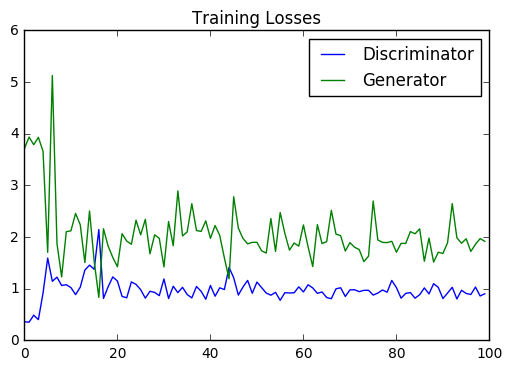

In [52]:
# Training loss

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [53]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

(<matplotlib.figure.Figure at 0x7f9b4a622810>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b4a4ef0d0>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f9b4ab0f2d0>]], dtype=object))

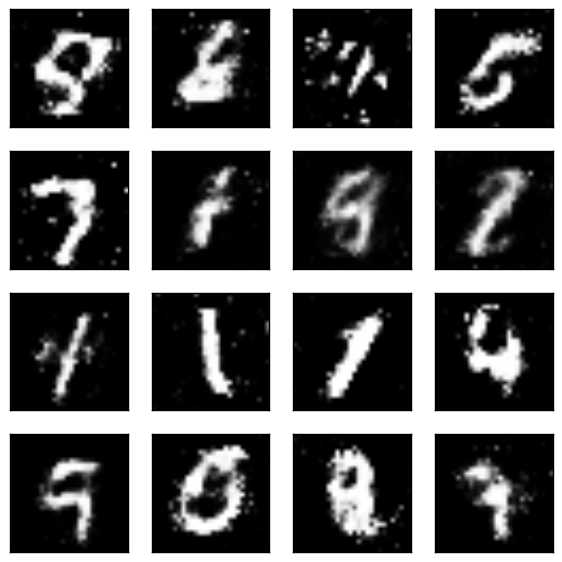

In [56]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

view_samples(-1, samples)

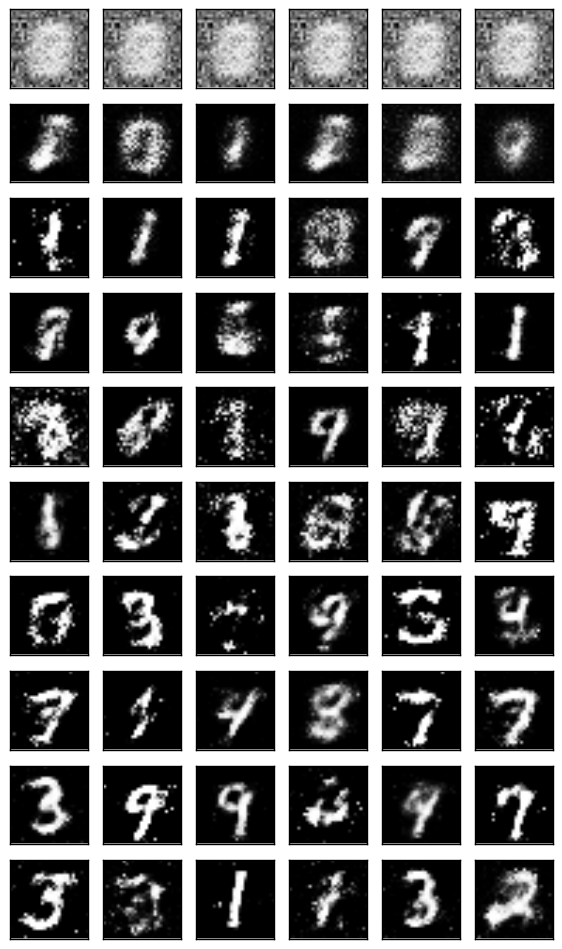

In [57]:
# Sample from every 10 epochs
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

(<matplotlib.figure.Figure at 0x7f9b56525250>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b42427250>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f9b41e86a10>]], dtype=object))

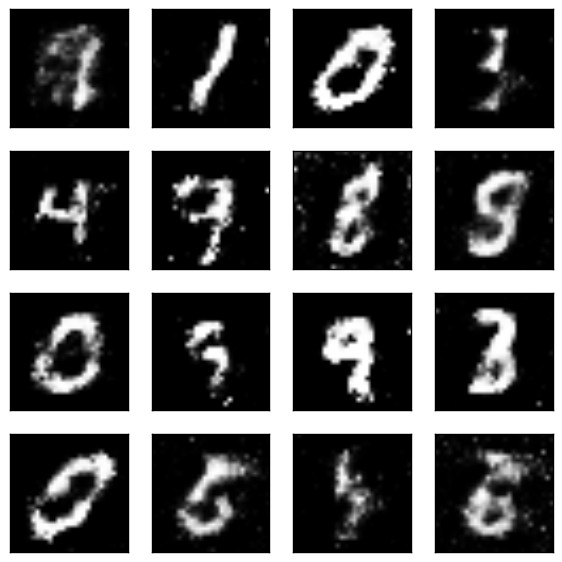

In [60]:
# Sampling from the generator

saver = tf.train.Saver(var_list=generator_variables)
with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('checkpoints'))
    sample_generator = np.random.uniform(-1, 1, size=(16, generator_input_size))
    samples = session.run(
                   generator(generator_input, discriminator_input_size, reuse=True),
                   feed_dict={generator_input: sample_generator})
view_samples(0, [samples])